In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from FinancialMachineLearning.features.concurrency import *
from FinancialMachineLearning.multiprocess import multiprocess

/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/fast_ewma.py:5: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((float64[:], int64), nopython = False, nogil = True)


In [2]:
dollar = pd.read_csv('../../Data/dollar_IVEfuture.csv', index_col = 0, parse_dates = True)
dollar = dollar[~dollar.index.duplicated(keep = 'first')]
dollar

,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
date_time,,,,,,,,,
2009-09-28 09:46:34,80,50.79,51.070,50.7100,51.07,20044,13264,80,1.020027e+06
2009-09-28 09:52:47,142,51.07,51.148,51.0500,51.13,21024,19774,62,1.073986e+06
2009-09-28 09:54:38,201,51.14,51.150,51.1290,51.13,19951,6951,59,1.020145e+06
2009-09-28 09:55:26,243,51.13,51.150,51.1300,51.14,19652,18052,42,1.004999e+06
2009-09-28 10:02:48,339,51.14,51.260,51.0800,51.25,19943,11354,96,1.020512e+06
...,...,...,...,...,...,...,...,...,...
2023-09-14 15:54:32,10930083,162.98,163.060,162.9654,162.98,6186,3983,39,1.008408e+06
2023-09-14 15:59:20,10930131,162.99,163.040,162.9299,163.04,7158,4629,48,1.166735e+06
2023-09-14 15:59:39,10930171,163.04,163.050,162.9900,163.00,6316,3266,40,1.029639e+06


#### Estimated Volatility

In [4]:
from FinancialMachineLearning.features.volatility import daily_volatility
vol = daily_volatility(dollar.close, lookback = 100)

<Axes: xlabel='date_time'>

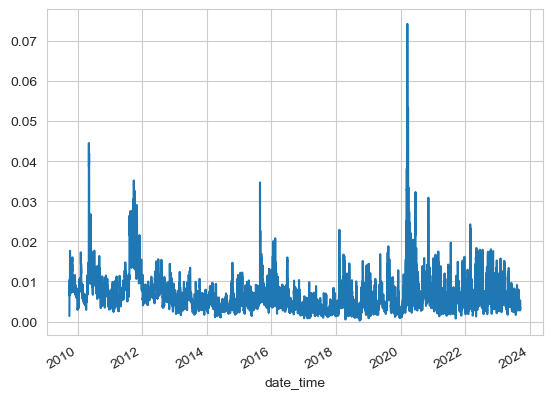

In [5]:
vol.plot()

#### CUSUM Filtering

In [6]:
from FinancialMachineLearning.filter.filter import cusum_filter
cusum_events = cusum_filter(dollar.close, threshold = vol.mean())

In [7]:
cusum_events

DatetimeIndex(['2009-09-28 09:52:47', '2009-09-28 09:55:26',
               '2009-09-28 10:02:48', '2009-09-28 10:10:21',
               '2009-09-28 10:14:19', '2009-09-28 10:23:42',
               '2009-09-28 10:34:30', '2009-09-28 10:44:48',
               '2009-09-28 11:02:36', '2009-09-28 11:15:44',
               ...
               '2023-09-14 15:01:31', '2023-09-14 15:07:06',
               '2023-09-14 15:19:35', '2023-09-14 15:36:28',
               '2023-09-14 15:46:26', '2023-09-14 15:54:32',
               '2023-09-14 15:59:20', '2023-09-14 15:59:39',
               '2023-09-14 15:59:59', '2023-09-14 16:00:00'],
              dtype='datetime64[ns]', length=196440, freq=None)

#### add Vertical barrier

In [8]:
from FinancialMachineLearning.labeling.labeling import *
vertical_barrier = add_vertical_barrier(cusum_events, dollar['close'], num_days = 1)

In [9]:
vertical_barrier

2009-09-28 09:52:47   2009-09-29 10:00:18
2009-09-28 09:55:26   2009-09-29 10:00:18
2009-09-28 10:02:48   2009-09-29 10:05:41
2009-09-28 10:10:21   2009-09-29 10:17:47
2009-09-28 10:14:19   2009-09-29 10:17:47
                              ...        
2023-09-13 15:55:22   2023-09-14 15:59:20
2023-09-13 15:58:53   2023-09-14 15:59:20
2023-09-13 15:59:39   2023-09-14 15:59:39
2023-09-13 15:59:59   2023-09-14 15:59:59
2023-09-13 16:00:00   2023-09-14 16:00:00
Name: date_time, Length: 196410, dtype: datetime64[ns]

#### Triple Barrier Methods

In [10]:
triple_barrier_events = get_events(close = dollar['close'],
                                   t_events = cusum_events[34:],
                                   pt_sl = [1, 1],
                                   target = vol,
                                   min_ret = 0.01,
                                   num_threads = 1,
                                   vertical_barrier_times = vertical_barrier,
                                   side_prediction = None)
triple_barrier_events

/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/labeling/labeling.py:17: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for loc, vertical_barrier in events_['t1'].fillna(close.index[-1]).iteritems():
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/multiprocess.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df0 = df0.append(i)


,t1,trgt,pt,sl
2009-10-02 09:31:33,2009-10-02 10:35:54,0.010011,1,1
2009-10-02 09:44:59,2009-10-02 10:35:54,0.010268,1,1
2009-10-02 09:53:14,2009-10-05 09:35:17,0.010379,1,1
2009-10-02 10:01:56,2009-10-05 09:35:17,0.010430,1,1
2009-10-02 10:09:13,2009-10-05 09:35:17,0.010453,1,1
...,...,...,...,...
2023-05-08 15:16:20,2023-05-09 15:24:47,0.010701,1,1
2023-05-08 15:16:37,2023-05-09 15:24:47,0.010595,1,1
2023-05-08 15:36:39,2023-05-09 15:40:39,0.010387,1,1
2023-05-08 15:47:11,2023-05-09 15:48:38,0.010283,1,1


#### Concurrency

In [13]:
num_threads = 1
num_conc_events = multiprocess.mp_pandas_obj(concurrent_events, ('molecule', triple_barrier_events.index), num_threads, close_series_index = dollar.close.index, label_endtime = triple_barrier_events['t1'])

/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/features/concurrency.py:11: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t_in, t_out in label_endtime.iteritems():
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/multiprocess.py:42: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df0 = pd.Series()
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/multiprocess.py:47: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df0 = df0.append(i)


In [14]:
# num_conc_events = num_conc_events.loc[~num_conc_events.index.duplicated(keep = 'last')]

num_conc_events = num_conc_events.reindex(dollar.close.index).fillna(0)

In [15]:
num_conc_events

date_time
2009-09-28 09:46:34    0.0
2009-09-28 09:52:47    0.0
2009-09-28 09:54:38    0.0
2009-09-28 09:55:26    0.0
2009-09-28 10:02:48    0.0
                      ... 
2023-09-14 15:54:32    0.0
2023-09-14 15:59:20    0.0
2023-09-14 15:59:39    0.0
2023-09-14 15:59:59    0.0
2023-09-14 16:00:00    0.0
Length: 215833, dtype: float64

Text(0.5, 1.0, 'Label Concurrency versus EWMA Volatility')

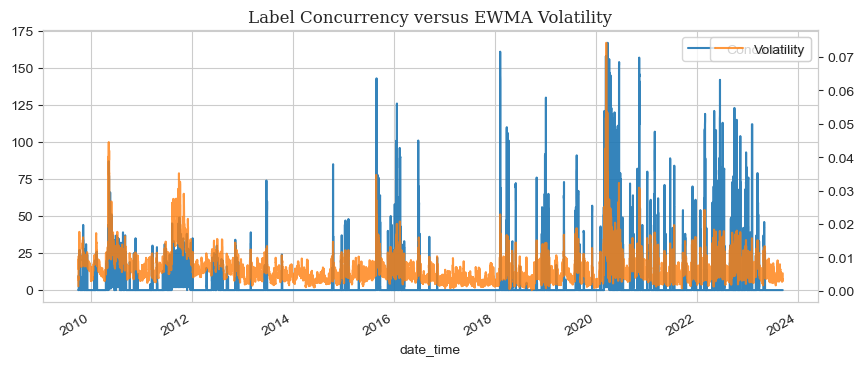

In [16]:
num_conc_events.plot(figsize = (10, 4), alpha = 0.9)
plt.legend(['Concurrency'])
vol.plot(secondary_y = True, alpha = 0.8)
plt.legend(['Volatility'])
plt.title('Label Concurrency versus EWMA Volatility', fontfamily = 'Serif', fontsize = 12)

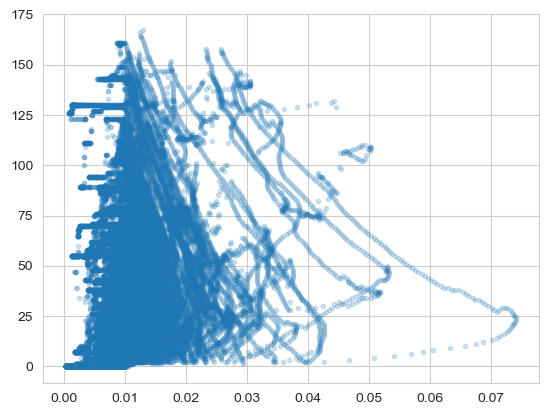

In [17]:
plt.scatter(vol[1:], num_conc_events[42:], marker = '.', alpha = 0.2)

#### Uniqueness

In [18]:
avg_unique = multiprocess.mp_pandas_obj(average_uniqueness, ('molecule', triple_barrier_events.index), num_threads, 
                                 label_endtime = triple_barrier_events['t1'], num_conc_events = num_conc_events)
avg_unique

/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/features/concurrency.py:15: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wght = pd.Series(index=molecule)
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/features/concurrency.py:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t_in, t_out in label_endtime.loc[wght.index].iteritems():
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/multiprocess.py:42: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df0 = pd.Series()
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/multiprocess.py:47: F

2009-10-02 09:31:33    0.275361
2009-10-02 09:44:59    0.202897
2009-10-02 09:53:14    0.135099
2009-10-02 10:01:56    0.130016
2009-10-02 10:09:13    0.126859
                         ...   
2023-05-08 15:16:20    0.073810
2023-05-08 15:16:37    0.074945
2023-05-08 15:36:39    0.107179
2023-05-08 15:47:11    0.124807
2023-05-08 15:54:13    0.161731
Length: 30053, dtype: float64

<Axes: >

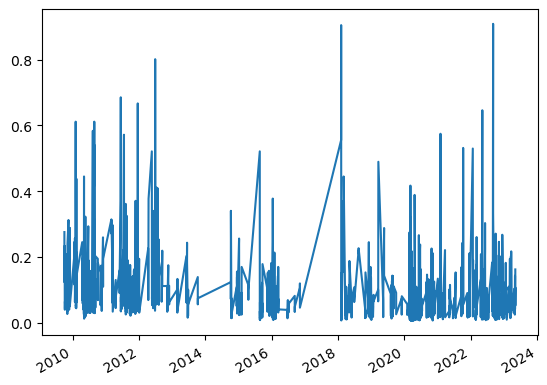

In [24]:
avg_unique.plot()

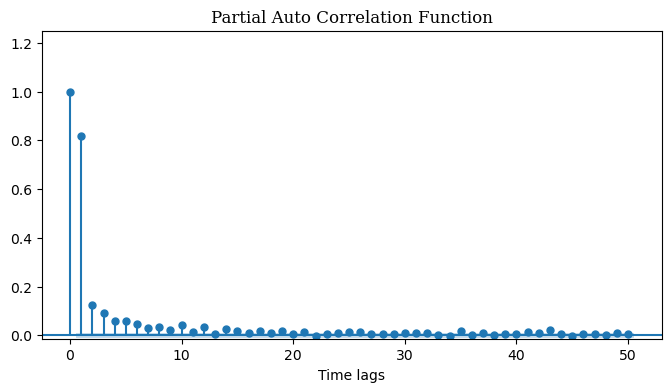

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(8, 4))
plot_pacf(avg_unique, auto_ylims = True, lags = 50, ax = ax)
plt.xlabel('Time lags', fontsize = 10)
plt.title('Partial Auto Correlation Function', fontsize = 12, fontfamily = 'Serif')
plt.show()

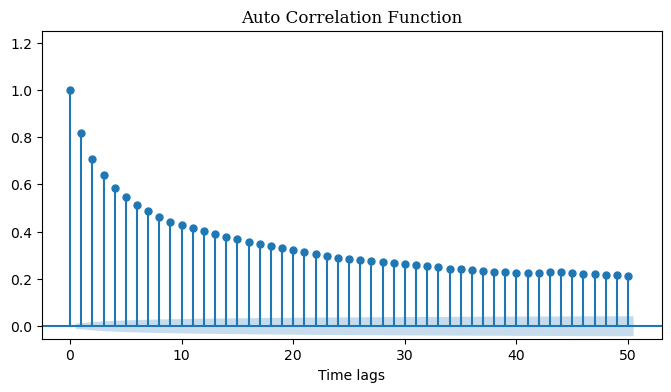

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(8, 4))
plot_acf(avg_unique, auto_ylims = True, lags = 50, ax = ax)
plt.xlabel('Time lags', fontsize = 10)
plt.title('Auto Correlation Function', fontsize = 12, fontfamily = 'Serif')
plt.show()